In [138]:
%matplotlib inline
import torch 
from torch.nn import Module,Conv2d,MaxPool2d,ReLU,Sequential,Linear
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import os
import PIL
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim

In [139]:
class LoadDataset():
  def __init__(self,imageFolder,transform=None):
    self.imageFolder = imageFolder
    self.transform = transform

  def __getitem__(self,index):

    image = random.choice(self.imageFolder.imgs)
    random_image1 = random.choice(self.imageFolder.imgs)
    random_image2 = random.choice(self.imageFolder.imgs)

    
    while(random_image1[1] != image[1]):
      random_image1 = random.choice(self.imageFolder.imgs)

    while(random_image2[1] == image[1]):
      random_image2 = random.choice(self.imageFolder.imgs)

    image = PIL.Image.open(image[0])
    random_image1 = PIL.Image.open(random_image1[0])
    random_image2 = PIL.Image.open(random_image2[0])

#    print(random_image1.shape)

    

    image = image.convert("L")
    random_image1 = random_image1.convert("L")
    random_image2 = random_image2.convert("L")

    if(self.transform):
      image = self.transform(image)
      random_image1 = self.transform(random_image1)
      random_image2 = self.transform(random_image2)

    return (image,random_image1,torch.from_numpy(np.array(0,dtype = np.float32))),(image,random_image2,torch.from_numpy(np.array(1,dtype = np.float32)))

  def __len__(self):
    return len(self.imageFolder.imgs)
    
  


In [140]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


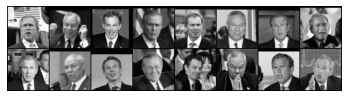

[0. 0. 0. 0. 0. 0. 0. 0.]


In [141]:
Siamese_DataLoader = ImageFolder(root = "Train")
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)),
  torchvision.transforms.ToTensor()])

Siamese_Dataset = LoadDataset(imageFolder=Siamese_DataLoader,transform=transformations)
visualize_data = DataLoader(Siamese_Dataset,shuffle=True,batch_size=8)
batch = next(iter(visualize_data))
concatenated_Images = torch.cat((batch[0][0],batch[0][1]),0)
imshow(torchvision.utils.make_grid(concatenated_Images))
print(batch[0][2].numpy().reshape(-1))

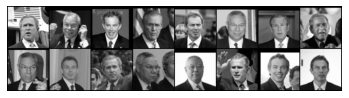

[1. 1. 1. 1. 1. 1. 1. 1.]


In [142]:
concatenated_Images = torch.cat((batch[1][0],batch[1][1]),0)
imshow(torchvision.utils.make_grid(concatenated_Images))
print(batch[1][2].numpy().reshape(-1))

In [143]:
class Siamese_Network(Module):

  def __init__(self):
    super(Siamese_Network,self).__init__()

    self.cnn = Sequential(
            Conv2d(1, 96, kernel_size=11,stride=4),
            ReLU(inplace=True),
            MaxPool2d(3, stride=2),
            
            Conv2d(96, 256, kernel_size=5, stride=1),
            ReLU(inplace=True),
            MaxPool2d(2, stride=2),

            Conv2d(256, 384, kernel_size=3,stride=1),
            ReLU(inplace=True)
    )

    self.connected = Sequential(
            Linear(384, 1024),
            ReLU(inplace=True),
            
            Linear(1024, 256),
            ReLU(inplace=True),
            
            Linear(256,3)
    )

  def forward_once(self,input):
    output = self.cnn(input)
    output = self.connected(output.view(output.size()[0],-1))
    return output

  def forward(self,anchor,positive,negative):
    output_anchor = self.forward_once(anchor)
    output_positive = self.forward_once(positive)
    output_negative = self.forward_once(negative)
    return output_anchor,output_positive,output_negative



In [144]:
class TripletLoss(Module):
  def __init__(self,margin=2.0):
    super(TripletLoss,self).__init__()
    self.margin = margin

  def forward(self,anchor,positive,negative):
    res = torch.clamp(functional.pairwise_distance(anchor,positive)-functional.pairwise_distance(anchor,negative)+self.margin,min=0.0)
    return res
    

In [145]:
Siamese_Model = Siamese_Network()
adam = optim.Adam(Siamese_Model.parameters(),lr=0.0005)
Triplet_Loss = TripletLoss()
Siamese_Dataset = LoadDataset(imageFolder=Siamese_DataLoader,transform=transformations)
Train_data = DataLoader(Siamese_Dataset,shuffle=True,batch_size=24)

In [147]:
counter = []
loss_history = []
iteration_number= 0
for i in range(1):
  for j,batch in enumerate(Train_data,0):
    
    adam.zero_grad()
    anchor = batch[0][0]
    positive = batch[0][1]
    positive_label = batch[0][2]

    negative = batch[1][1]
    negative_label = batch[1][2]

    

    y_anchor,y_positive,y_negative = Siamese_Model(anchor,positive,negative)
    TripletLoss = Triplet_Loss(y_anchor,y_positive,y_negative)
    TripletLoss.mean().backward()
    adam.step()
    
    if j % 10 == 0 :
            print(f"Epoch number {i}\n Current loss {TripletLoss.mean().item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(TripletLoss.mean().item())
      
show_plot(counter, loss_history)

  

Epoch number 0
 Current loss 1.9995613098144531

Epoch number 0
 Current loss 2.045069456100464



KeyboardInterrupt: 

In [ ]:
folder_dataset_test = ImageFolder(root="positives")
siamese_dataset = LoadDataset(imageFolder=folder_dataset_test,transform=transformations)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0 = next(dataiter)
#print(x0,x1,x2)

for i in range(20):
    x1 = next(dataiter)

    concatenated = torch.cat((x0[0][0], x1[0][0]), 0)

    output1, output2 = Siamese_Model(x0[0][0], x1[0][0])
    euclidean_distance = functional.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')


In [ ]:
model_scripted = torch.jit.script(Siamese_Model) 
model_scripted.save('TripletLoss.pt') 